
Zero-Coupon Yields Results:
Maturity (years) | Discount Factor | Zero-Coupon Yield (%)
------------------------------------------------------------
          0.08 |         0.9964 |             4.3378
          0.25 |         0.9893 |             4.3132
          0.50 |         0.9789 |             4.2652
          1.00 |         0.9586 |             4.2281
          2.00 |         0.9186 |             4.2450
          3.00 |         0.8791 |             4.2962
          5.00 |         0.8034 |             4.3781
          7.00 |         0.7313 |             4.4713
         10.00 |         0.6335 |             4.5644
         30.00 |         0.2380 |             4.7856


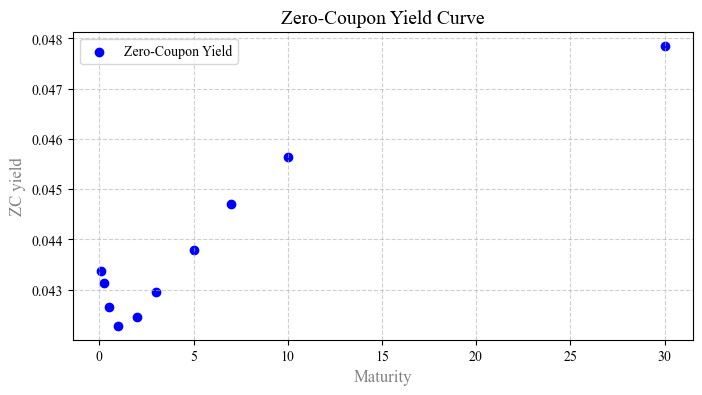

In [5]:
# 1
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

class ZeroCouponCalculator:
    def __init__(self):
        # Store yields for bills (expressed as percentages)
        self.bills_yields = {
            1/12: 4.33,  # 1-month
            1/4: 4.29,   # 3-month
            1/2: 4.22,   # 6-month
            1.0: 4.14    # 1-year
        }
        
        # Calculate discount factors for bills using yield
        self.bills_discount_factors = {
            t: 1 - y / 100 * t for t, y in self.bills_yields.items()
        }
        
        # Store known rates for bonds
        self.bond_rates = {
            2.0: 4.29,
            3.0: 4.34,
            5.0: 4.42,
            7.0: 4.51,
            10.0: 4.60,
            30.0: 4.82
        }
        
    def get_discount_factor(self, t):
        """
        Get discount factor for time t
        For t <= 1: retrieve from bills_discount_factors
        For 1 < t: interpolate if needed
        """
        if t in self.bills_discount_factors:
            return self.bills_discount_factors[t]
        elif t <= 1:
            # Find surrounding points and interpolate
            times = sorted(self.bills_discount_factors.keys())
            idx = np.searchsorted(times, t)
            t1, t2 = times[idx-1], times[idx]
            d1 = self.bills_discount_factors[t1]
            d2 = self.bills_discount_factors[t2]
            return (d1+d2)/2
        return None

    def calculate_bond_discount_factor(self, T, rate):
        """Calculate discount factor for a bond with maturity T"""
        rate = rate / 100  # Convert to decimal
        
        def bond_price_equation(P):
            price = 0
            # Calculate semi-annual coupon payments
            for i in range(1, int(T * 2) + 1):
                t = i / 2
                if t <= 1:
                    # Use stored bills discount factors
                    df = self.get_discount_factor(t)
                elif t > 1 and t < T:
                    if t.is_integer():
                        if t in self.bond_discount_factors:
                            df = self.bond_discount_factors[t]
                        else:
                            df = P ** (t / T)
                    else:
                        # For non-integer t > 1, use average of surrounding points
                        t_floor = int(t)
                        t_ceil = t_floor + 1
                        if t_floor == 1:
                            df_floor = self.bills_discount_factors[1.0]
                        else:
                            df_floor = self.bond_discount_factors.get(t_floor, P ** (t_floor / T))
                        df_ceil = self.bond_discount_factors.get(t_ceil, P ** (t_ceil / T))
                        df = (df_floor + df_ceil) / 2
                else:  # t = T
                    df = P
                
                price += (rate * 100 / 2) * df
            
            # Add final payment
            price += 100 * P
            return price - 100
        
        # Solve for the discount factor
        initial_guess = 1 / (1 + rate) ** T
        P = fsolve(bond_price_equation, x0=initial_guess)[0]
        return P

    def calculate_all_discount_factors(self):
        """Calculate discount factors for all bonds"""
        self.bond_discount_factors = {}
        
        # Calculate discount factors in order of maturity
        for T in sorted(self.bond_rates.keys()):
            P = self.calculate_bond_discount_factor(T, self.bond_rates[T])
            self.bond_discount_factors[T] = P
            
        return self.bond_discount_factors

    def calculate_zero_coupon_yields(self):
        """Calculate zero-coupon yields for all maturities"""
        # Calculate bond discount factors
        self.calculate_all_discount_factors()
        
        # Combine all discount factors
        all_discount_factors = {**self.bills_discount_factors, **self.bond_discount_factors}
        
        # Calculate zero-coupon yields
        zero_coupon_yields = {}
        for t, df in sorted(all_discount_factors.items()):
            zcy = -1 / t * np.log(df) * 100
            zero_coupon_yields[t] = zcy
        
        return zero_coupon_yields

def main():
    calculator = ZeroCouponCalculator()
    zero_coupon_yields = calculator.calculate_zero_coupon_yields()
    
    # Print results
    print("\nZero-Coupon Yields Results:")
    print("Maturity (years) | Discount Factor | Zero-Coupon Yield (%)")
    print("-" * 60)
    
    maturities = []
    zc_yields = []
    
    for t in sorted(zero_coupon_yields.keys()):
        df = calculator.bills_discount_factors.get(t) or calculator.bond_discount_factors.get(t)
        zcy = zero_coupon_yields[t]
        maturities.append(t)
        zc_yields.append(zcy / 100)  # Convert to decimal format
        
        print(f"{t:14.2f} | {df:14.4f} | {zcy:18.4f}")

    # Plot scatter chart
    plt.figure(figsize=(8, 4))
    plt.scatter(maturities, zc_yields, color='blue', label="Zero-Coupon Yield")

    # Labels and formatting
    plt.xlabel("Maturity", fontsize=12, color='gray')
    plt.ylabel("ZC yield", fontsize=12, color='gray')
    plt.title("Zero-Coupon Yield Curve", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the chart
    plt.show()

if __name__ == "__main__":
    main()
    

In [4]:
import pandas as pd

# Define data
data = {
    "Maturity (years)": [0.08, 0.25, 0.50, 1.00, 2.00, 3.00, 5.00, 7.00, 10.00, 30.00],
    "Discount Factor": [0.9964, 0.9893, 0.9789, 0.9586, 0.9186, 0.8791, 0.8034, 0.7313, 0.6335, 0.2380],
    "Zero-Coupon Yield (%)": [4.3378, 4.3132, 4.2652, 4.2281, 4.2450, 4.2962, 4.3781, 4.4713, 4.5644, 4.7856]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
df

,Maturity (years),Discount Factor,Zero-Coupon Yield (%)
0,0.08,0.9964,4.3378
1,0.25,0.9893,4.3132
2,0.50,0.9789,4.2652
3,1.00,0.9586,4.2281
4,2.00,0.9186,4.2450
5,3.00,0.8791,4.2962
6,5.00,0.8034,4.3781
7,7.00,0.7313,4.4713
8,10.00,0.6335,4.5644
9,30.00,0.2380,4.7856


In [17]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def nss_yield(t, params):
    """
    Calculate yield using Nelson-Siegel-Svensson function
    params: [a, b, c, d, tau, theta]
    """
    a, b, c, d, tau, theta = params
    
    # Handle very small t values to avoid division by zero
    if t < 1e-10:
        t = 1e-10
    
    factor1 = (1 - np.exp(-t/tau)) / (t/tau)
    factor2 = factor1 - np.exp(-t/tau)
    factor3 = (1 - np.exp(-t/theta)) / (t/theta) - np.exp(-t/theta)
    
    return a + b*factor1 + c*factor2 + d*factor3

def objective_function(params, maturities, yields, weighted=True):
    """
    Calculate weighted sum of squared errors between actual and fitted yields
    With special weighting for short-end (1/t) and long-end (t) of the curve
    """
    fitted_yields = np.array([nss_yield(t, params) for t in maturities])
    errors = yields - fitted_yields
    
    if weighted:
        # Apply weights: 1/t for short end, t for long end
        # Use maturity of 2 years as the threshold between short and long end
        threshold = 2.0
        weights = np.where(maturities <= threshold, 
                          1/maturities,  # Short end: weight by 1/t
                          maturities)    # Long end: weight by t
        
        # Apply weights to squared errors
        weighted_errors = errors * errors * weights
        return np.sum(weighted_errors)
    else:
        return np.sum(errors * errors)

def fit_nss(maturities, yields, weighted=True):
    """
    Fit Nelson-Siegel-Svensson model to the yield curve
    """
    # Initial parameter guess
    initial_guess = [
        0.01,  # a (long-term level)
        0.01,   # b
        1.0,    # c
        -1.0,   # d
        1.0,    # tau
        1.0     # theta
    ]
    
    # Parameter bounds
    bounds = [
        (0, 0.1),     # a
        (-0.1, 0.1),  # b
        (-2, 2),      # c
        (-2, 2),      # d
        (0.1, 10),    # tau
        (0.1, 10)     # theta
    ]
    
    # Minimize objective function
    result = minimize(
        objective_function,
        initial_guess,
        args=(maturities, yields, weighted),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    return result

# Example usage (assuming you have zero_coupon_yields from previous code):
calculator = ZeroCouponCalculator()
zero_coupon_yields = calculator.calculate_zero_coupon_yields()

# Convert dictionary to arrays for fitting
maturities = np.array(list(zero_coupon_yields.keys()))
yields = np.array(list(zero_coupon_yields.values())) / 100  # Convert to decimal

# Fit NSS model with weighted objective function
result = fit_nss(maturities, yields, weighted=True)


param_names = ['a', 'b', 'c', 'd', 'τ', 'θ']

# Create DataFrame for parameters
df_params = pd.DataFrame({
    "Parameter": param_names,
    "Value": [round(value, 4) for value in result.x]
})

df_obj_func = pd.DataFrame({
    "Metric": ["Minimized Objective Function"],
    "Value": [round(result.fun, 2)]
})

df_params.T

# Create DataFrame for the minimized objective function


,0,1,2,3,4,5
Parameter,a,b,c,d,τ,θ
Value,0.0487,-0.0053,0.9932,-1.0069,0.996,1.0041


In [18]:
df_obj_func.T


,0
Metric,Minimized Objective Function
Value,0.0


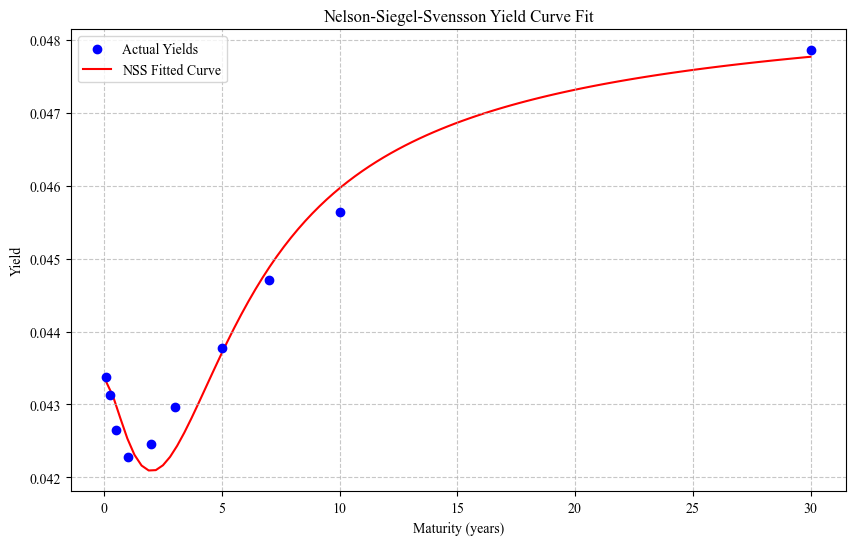

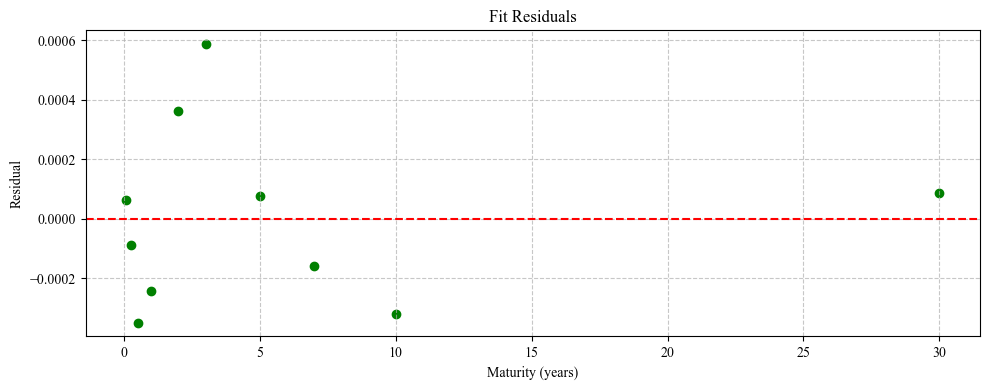

In [19]:
# Generate fitted curve for plotting
t_fine = np.linspace(min(maturities), max(maturities), 100)
fitted_yields = [nss_yield(t, result.x) for t in t_fine]

# Plot results
plt.figure(figsize=(10, 6))

# Plot actual yields
plt.scatter(maturities, yields, color='blue', label='Actual Yields', zorder=2)

# Plot fitted curve
plt.plot(t_fine, fitted_yields, 'r-', label='NSS Fitted Curve', zorder=1)

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Yield Curve Fit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Calculate and plot residuals
plt.figure(figsize=(10, 4))
fitted_at_points = np.array([nss_yield(t, result.x) for t in maturities])
residuals = yields - fitted_at_points

plt.scatter(maturities, residuals, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Maturity (years)')
plt.ylabel('Residual')
plt.title('Fit Residuals')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()